# Connecting to Samarjit's dj db

In [6]:
import datajoint as dj
import sys
import h5py
import matplotlib.pyplot as plt
import numpy as np
sys.path.append('/Users/riekelabbackup/Desktop/Vyom/gitrepos/samarjit_datajoint/next-app/api/')
import schema
import helpers.pop as pop

In [2]:
host_address, user, password = '127.0.0.1', 'root', 'simple'
dj.config["database.host"] = f"{host_address}"
dj.config["database.user"] = f"{user}"
dj.config["database.password"] = f"{password}"
dj.conn()

DataJoint connection (connected) root@127.0.0.1:3306

In [3]:
db = dj.VirtualModule('schema.py', 'schema')

In [4]:
data_dir = '/Volumes/Vyom MEA/data/samarjit_datajoint/data_dirs/data'
meta_dir = '/Volumes/Vyom MEA/data/samarjit_datajoint/data_dirs/meta'
tags_dir = '/Volumes/Vyom MEA/data/samarjit_datajoint/data_dirs/tags'
username = 'vyomr'
pop.append_data(data_dir, meta_dir, tags_dir, username, db)

  0%|          | 0/2 [00:00<?, ?it/s]

Adding /Volumes/Vyom MEA/data/samarjit_datajoint/data_dirs/meta/led_sawtooth_calibrations_20250210C.json


 50%|█████     | 1/2 [00:00<00:00,  4.10it/s]

Adding /Volumes/Vyom MEA/data/samarjit_datajoint/data_dirs/meta/led_sine_calibration_20250207C.json


100%|██████████| 2/2 [00:00<00:00,  5.74it/s]


2

In [194]:
str_h5 = '/Volumes/Vyom MEA/data/samarjit_datajoint/data_dirs/data/led_sawtooth_calibrations_20250210C.h5'
# str_h5 = '/Volumes/Vyom MEA/data/samarjit_datajoint/data_dirs/data/led_sine_calibration_20250207C.h5'
ex_q = schema.Experiment() & f'data_file="{str_h5}"'
ex_id = ex_q.fetch('id')[0]
ex_id

1

In [195]:
def get_epoch_data(ex_id):
    # # Given experiment id, get epoch data with epoch group labels
    # df = (schema.Epoch() & f'experiment_id={ex_id}').fetch(format='frame').reset_index()
    # df['epoch_group_label'] = ''
    # df['h5path'] = ''

    # # Get EG ids for ex_id
    # eg_ids = (schema.EpochGroup() & f'experiment_id={ex_id}').fetch('id')
    # for eg_id in eg_ids:
    #     # Get EB ids for EG ids
    #     eb_ids = (schema.EpochBlock() & f'parent_id={eg_id}').fetch('id')
    #     for eb_id in eb_ids:
    #         # Get E ids for EB ids
    #         e_ids = (schema.Epoch() & f'parent_id={eb_id}').fetch('id')
    #         df.loc[df['id'].isin(e_ids), 'epoch_group_label'] = (schema.EpochGroup() & f'id={eg_id}').fetch1('label')

    #         # Get h5_path for E ids
    #         for e_id in e_ids:
    #             df.loc[df['id']==e_id, 'h5path'] = (schema.Response() & f'parent_id={e_id}').fetch1('h5path')
    
    # Filter epochgroup by experiment_id, then join on EpochBlock, then join on Epoch
    eg_q = schema.EpochGroup() & f'experiment_id={ex_id}'
    eb_q = eg_q.proj(group_label='label', group_id='id') * schema.EpochBlock.proj(group_id='parent_id')
    e_q = eb_q.proj(..., block_id='id') * schema.Epoch.proj(epoch_parameters='parameters', block_id='parent_id', epoch_id='id')
    r_q = e_q * schema.Response.proj(..., epoch_id='parent_id', response_id='id') 
    df = r_q.fetch(format='frame').reset_index()
    
    return df
df_e = get_epoch_data(ex_id)
df_e.head()

group_id  block_id  epoch_id  response_id group_label  \
0         1         1         1            1   0.01 mean   
1         1         1         2            2   0.01 mean   
2         1         1         3            3   0.01 mean   
3         1         1         4            4   0.01 mean   
4         1         1         5            5   0.01 mean   

                                    epoch_parameters  \
0  {'NDF': 0, 'amp': 'Amp1', 'led': 'Green LED', ...   
1  {'NDF': 0, 'amp': 'Amp1', 'led': 'Green LED', ...   
2  {'NDF': 0, 'amp': 'Amp1', 'led': 'Green LED', ...   
3  {'NDF': 0, 'amp': 'Amp1', 'led': 'Green LED', ...   
4  {'NDF': 0, 'amp': 'Amp1', 'led': 'Green LED', ...   

                                h5_uuid device_name  \
0  6dacde79-79f1-4a6d-9af5-d60c1d415747        Amp1   
1  f5b71b77-df08-4e4d-ba9d-56bb28cba0ea        Amp1   
2  72aed4bf-ce5e-42d5-a67e-e2f42d7a4831        Amp1   
3  230d3941-96d9-4e07-a5c9-bd8e4c43fd63        Amp1   
4  f0b39a1b-4228-4fba-b259-9a2c18270403        Amp1   

                                              h5path label sample_rate  \
0  /experiment-53ca7bba-9b6d-4de1-8088-05cf45020c...  None       10000   
1  /experiment-53ca7bba-9b6d-4de1-8088-05cf45020c...  None       10000   
2  /experiment-53ca7bba-9b6d-4de1-8088-05cf45020c...  None       10000   
3  /experiment-53ca7bba-9b6d-4de1-8088-05cf45020c...  None       10000   
4  /experiment-53ca7bba-9b6d-4de1-8088-05cf45020c...  None       10000   

  sample_rate_units offset_hours        offset_ticks  
0                Hz           -8  638748050055160196  
1                Hz           -8  638748050073080448  
2                Hz           -8  638748050093043357  
3                Hz           -8  638748050113029758  
4                Hz           -8  638748050132983290

In [196]:
# df['epoch_parameters'].iloc[0]
# Populate columns for currentContrast, currentFrequency, currentRapidOnOff
df_e['currentContrast'] = 0
df_e['currentFrequency'] = 0
df_e['currentRapidOnOff'] = 0
df_e['backgroundIntensity'] = 0
for idx in df_e.index:
    params = df_e.at[idx, 'epoch_parameters']
    df_e.at[idx, 'currentContrast'] = params['currentContrast']
    df_e.at[idx, 'currentFrequency'] = params['currentFrequency']
    df_e.at[idx, 'currentRapidOnOff'] = params['currentRapidOnOff']
    df_e.at[idx, 'backgroundIntensity'] = params['backgroundIntensity']
df_e.head()

group_id  block_id  epoch_id  response_id group_label  \
0         1         1         1            1   0.01 mean   
1         1         1         2            2   0.01 mean   
2         1         1         3            3   0.01 mean   
3         1         1         4            4   0.01 mean   
4         1         1         5            5   0.01 mean   

                                    epoch_parameters  \
0  {'NDF': 0, 'amp': 'Amp1', 'led': 'Green LED', ...   
1  {'NDF': 0, 'amp': 'Amp1', 'led': 'Green LED', ...   
2  {'NDF': 0, 'amp': 'Amp1', 'led': 'Green LED', ...   
3  {'NDF': 0, 'amp': 'Amp1', 'led': 'Green LED', ...   
4  {'NDF': 0, 'amp': 'Amp1', 'led': 'Green LED', ...   

                                h5_uuid device_name  \
0  6dacde79-79f1-4a6d-9af5-d60c1d415747        Amp1   
1  f5b71b77-df08-4e4d-ba9d-56bb28cba0ea        Amp1   
2  72aed4bf-ce5e-42d5-a67e-e2f42d7a4831        Amp1   
3  230d3941-96d9-4e07-a5c9-bd8e4c43fd63        Amp1   
4  f0b39a1b-4228-4fba-b259-9a2c18270403        Amp1   

                                              h5path label sample_rate  \
0  /experiment-53ca7bba-9b6d-4de1-8088-05cf45020c...  None       10000   
1  /experiment-53ca7bba-9b6d-4de1-8088-05cf45020c...  None       10000   
2  /experiment-53ca7bba-9b6d-4de1-8088-05cf45020c...  None       10000   
3  /experiment-53ca7bba-9b6d-4de1-8088-05cf45020c...  None       10000   
4  /experiment-53ca7bba-9b6d-4de1-8088-05cf45020c...  None       10000   

  sample_rate_units offset_hours        offset_ticks  currentContrast  \
0                Hz           -8  638748050055160196            0.005   
1                Hz           -8  638748050073080448            0.010   
2                Hz           -8  638748050093043357            0.020   
3                Hz           -8  638748050113029758            0.005   
4                Hz           -8  638748050132983290            0.010   

   currentFrequency  currentRapidOnOff  backgroundIntensity  
0                60                  1                 0.01  
1                60                  1                 0.01  
2                60                  1                 0.01  
3                60                  0                 0.01  
4                60                  0                 0.01

In [197]:
df_e['group_label'].unique()

array(['0.01 mean', '0.05 mean', '0.1 mean', '0.5 mean'], dtype=object)

In [198]:
import scipy.signal as signal

In [199]:
df_e['backgroundIntensity'][0]

0.01

In [200]:
def time_to_pts(t, sampleRate):
    return np.round(t / 1e3 * sampleRate).astype(int)

def sawtooth_generator(preTime, stimTime, tailTime, contrast, backgroundIntensity,
                       temporalFrequency, polarity, sampleRate):
    prePts = time_to_pts(preTime, sampleRate)
    stimPts = time_to_pts(stimTime, sampleRate)
    tailPts = time_to_pts(tailTime, sampleRate)

    amplitude = contrast * backgroundIntensity
    time = np.arange(stimPts) / sampleRate
    sawtooth = 2* (time * temporalFrequency - np.floor(time * temporalFrequency + 0.5))
    sawtooth = polarity * sawtooth

    sawtooth = backgroundIntensity + amplitude * sawtooth

    data = np.ones(prePts + stimPts + tailPts) * backgroundIntensity
    data[prePts:prePts + stimPts] = sawtooth

    return data

/var/folders/pt/ln41qs8d7vd36z1sgbgljbn00000gn/T/ipykernel_46850/1538626677.py:43: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  f, ax = plt.subplots(figsize=(25,5))


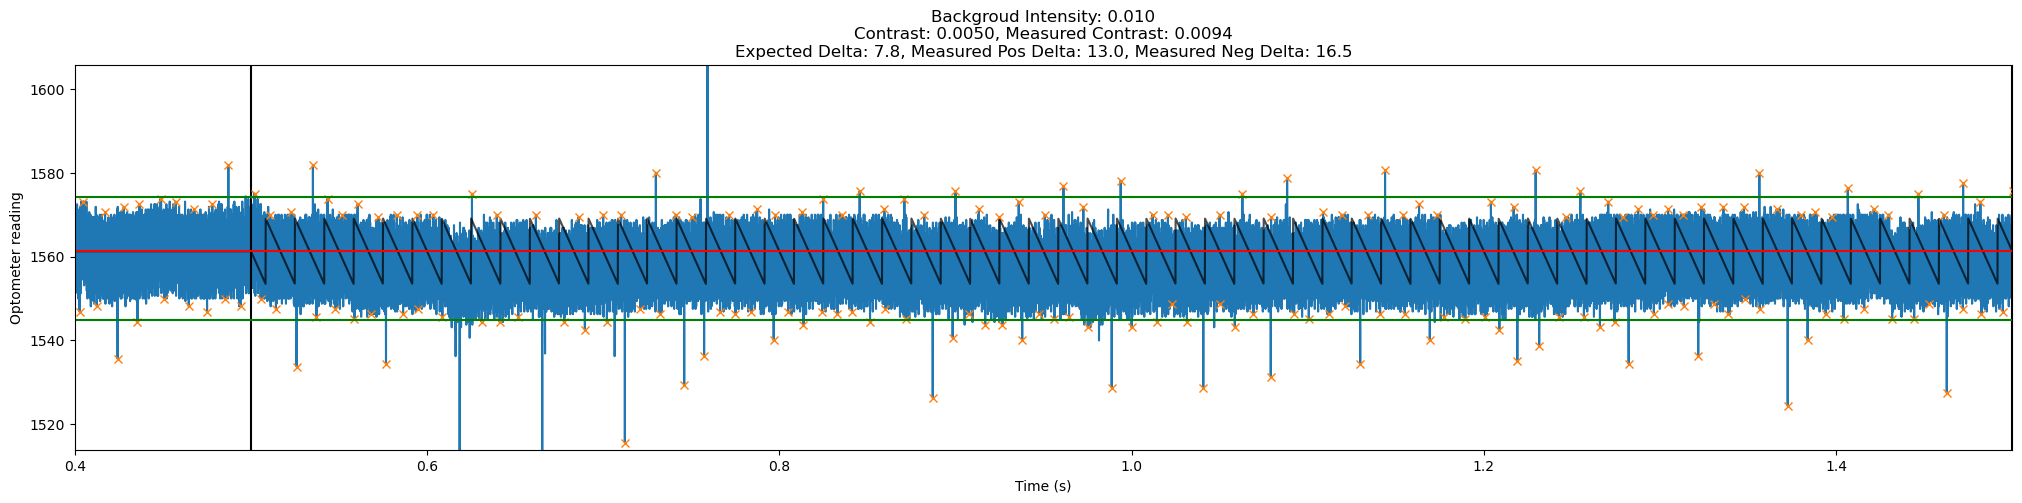

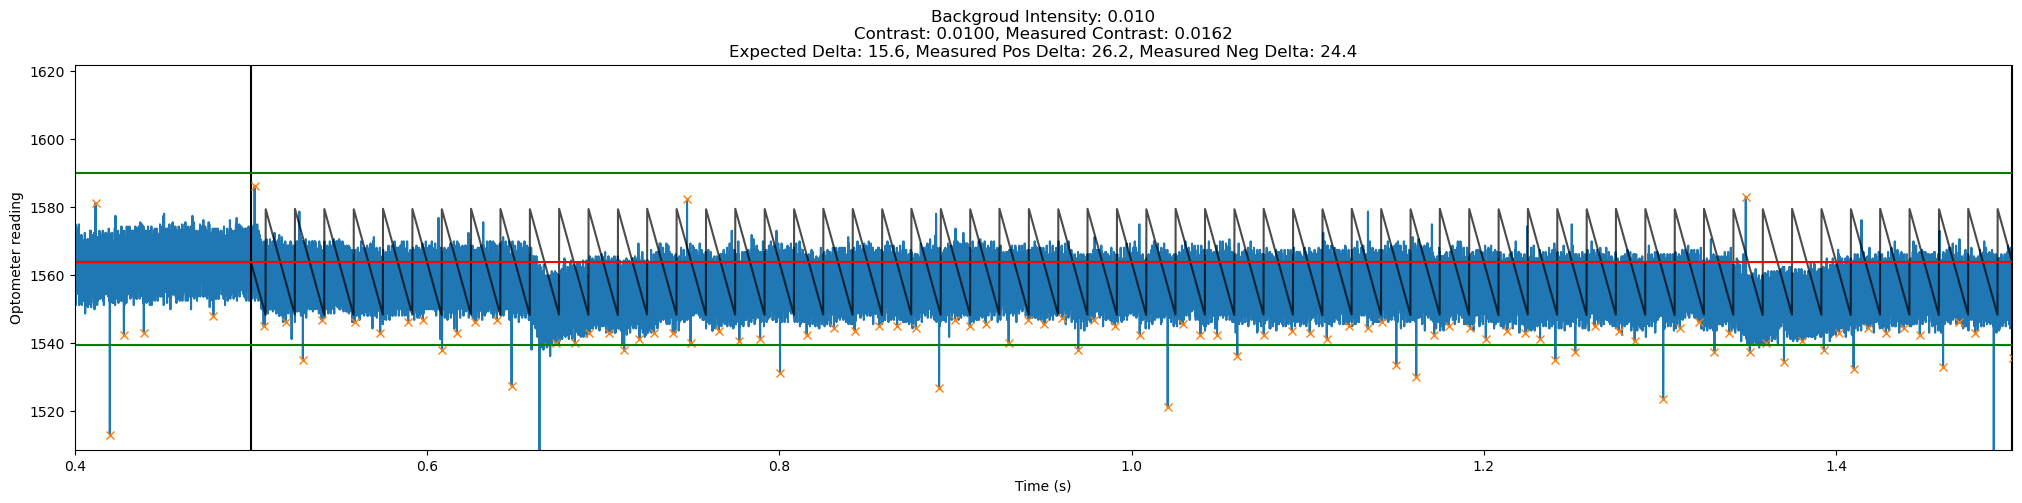

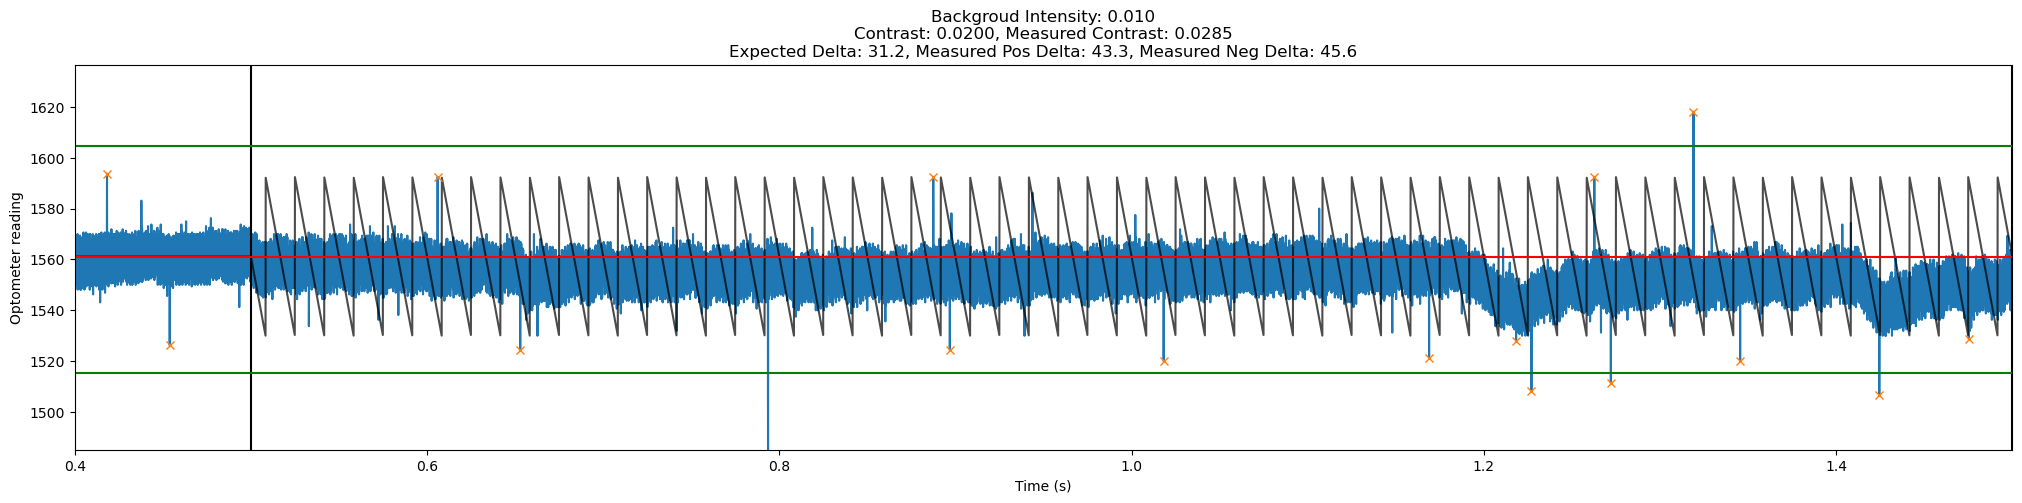

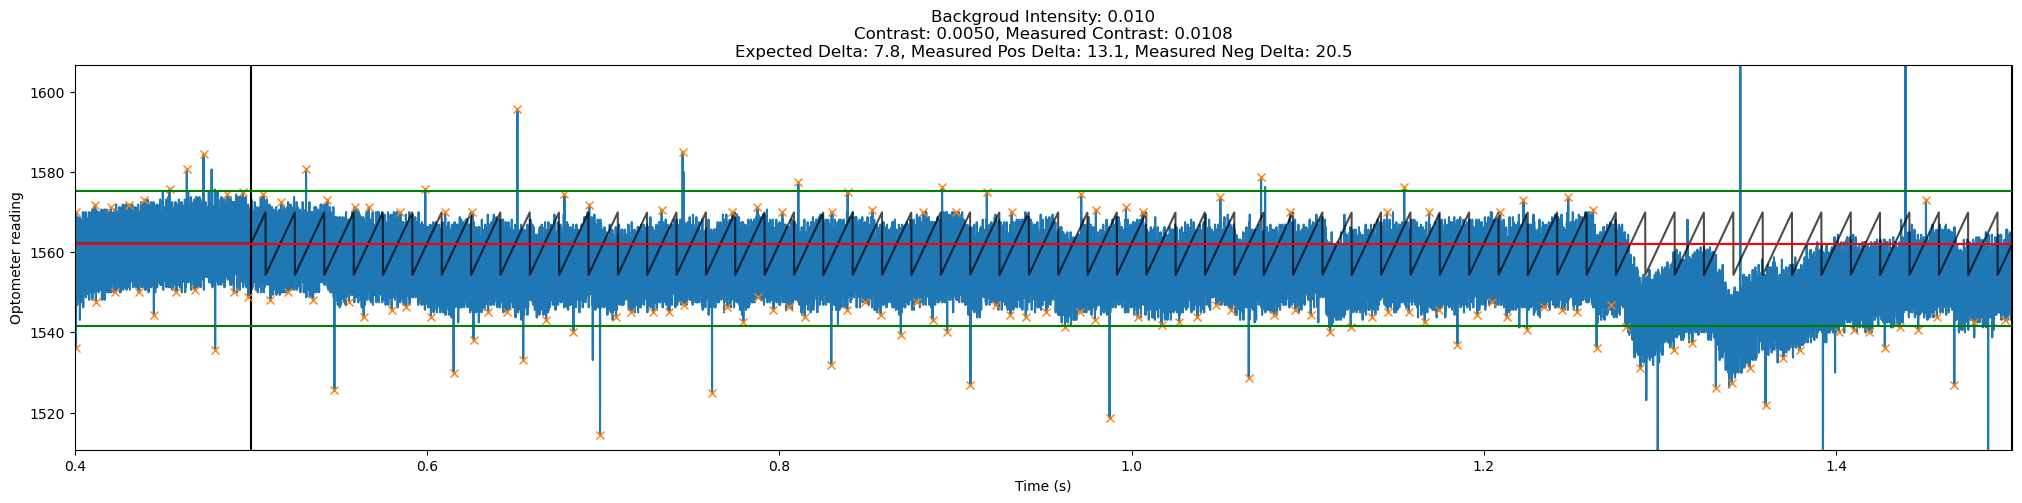

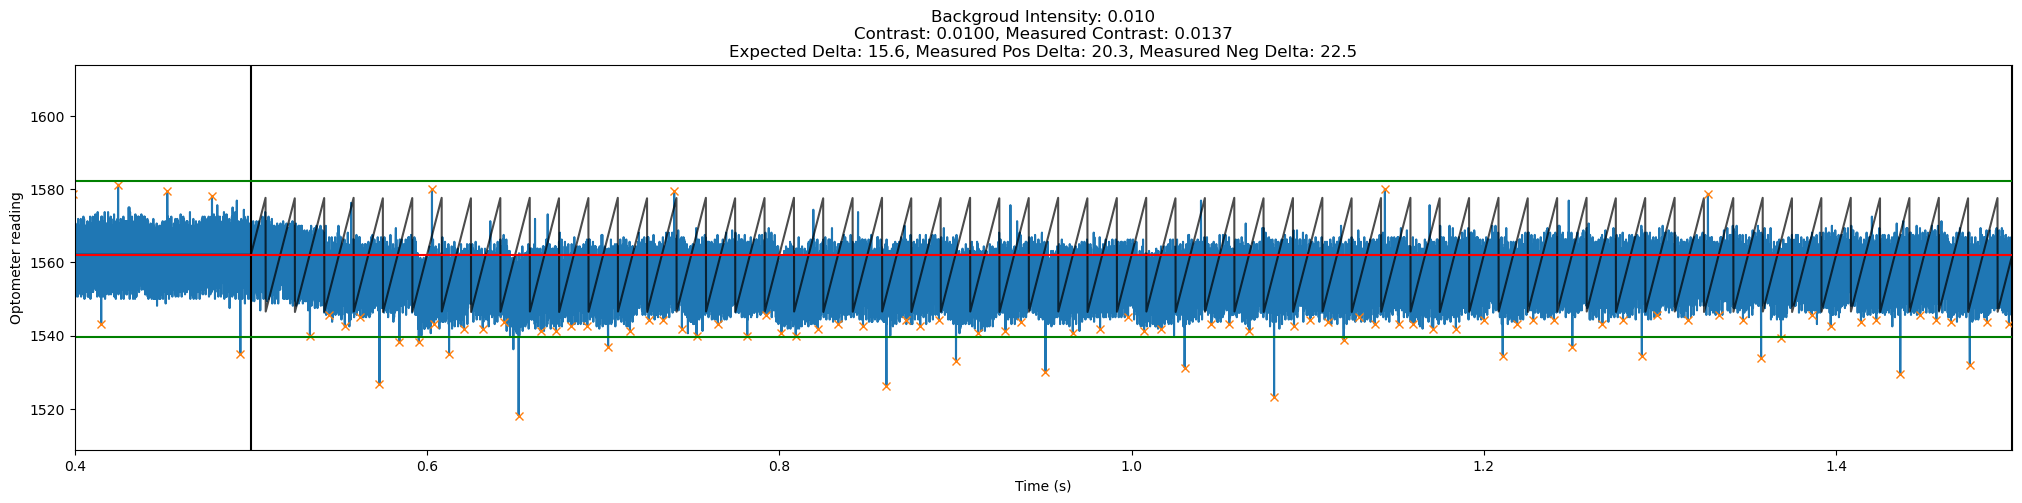

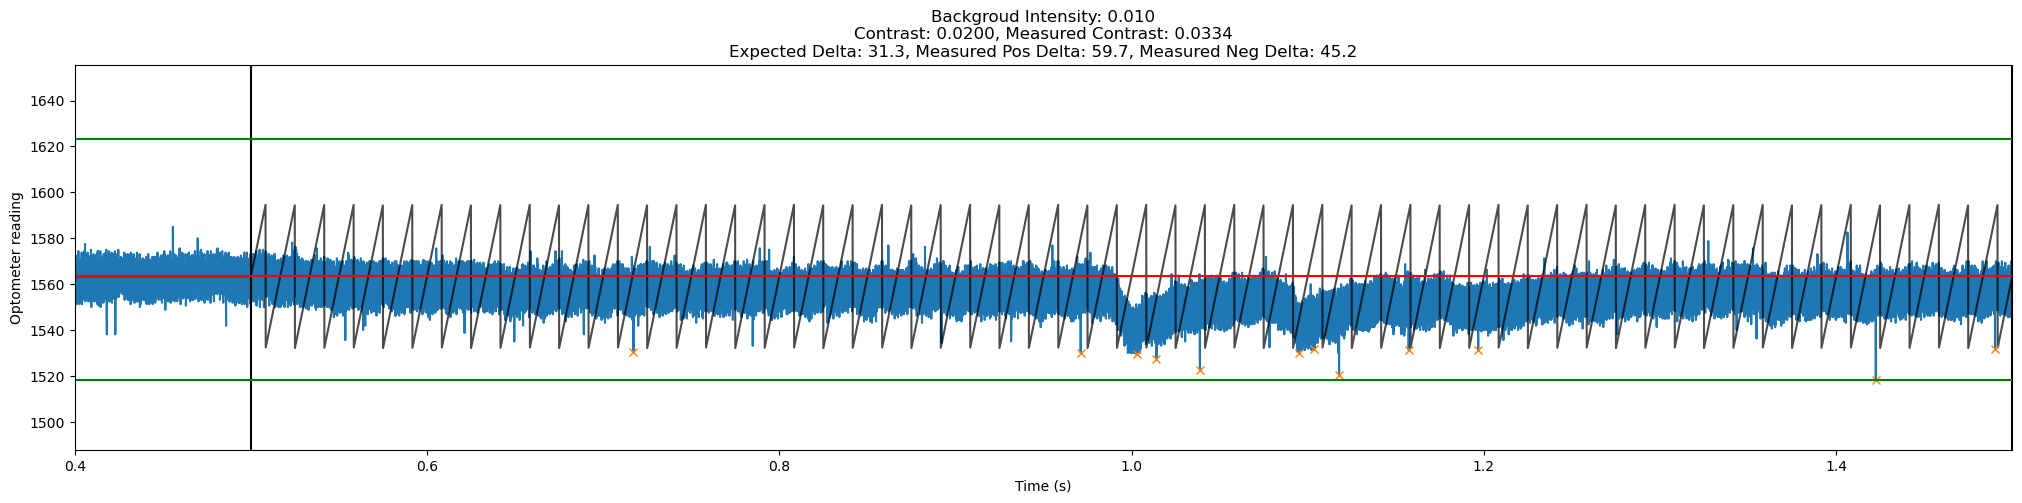

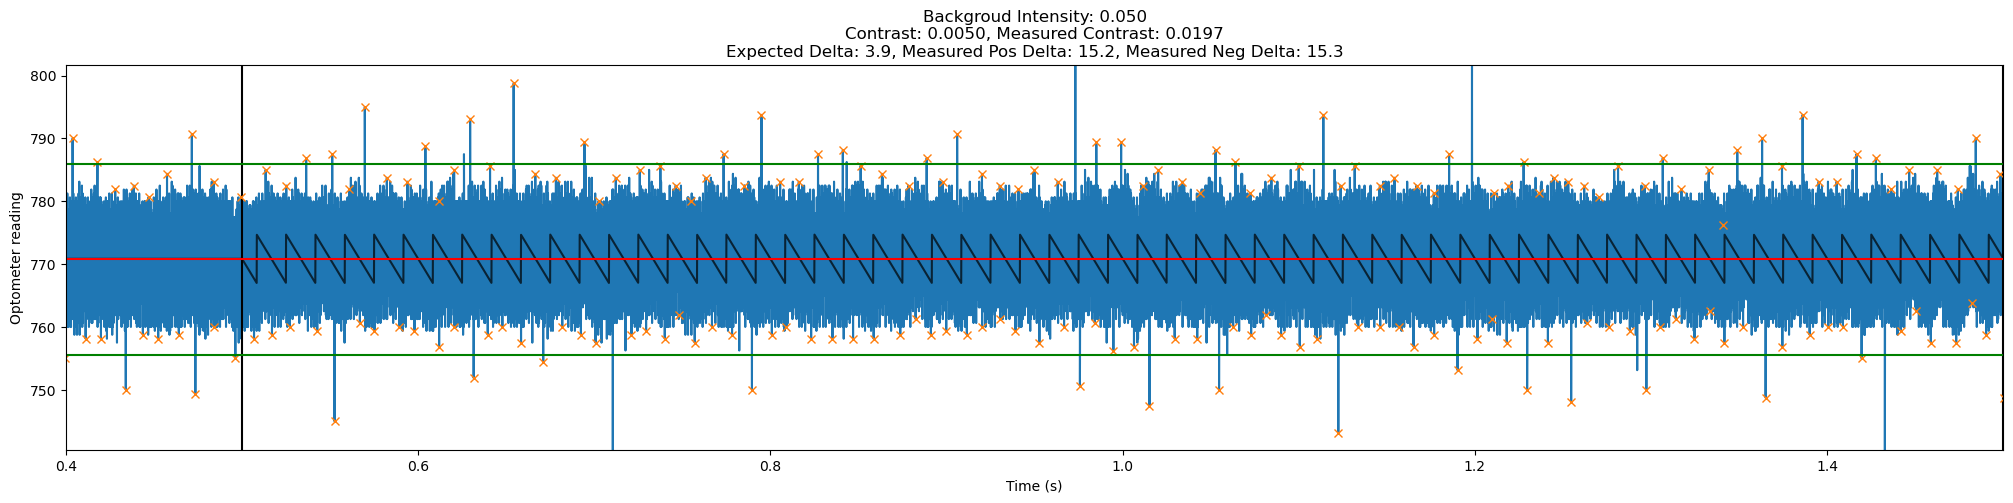

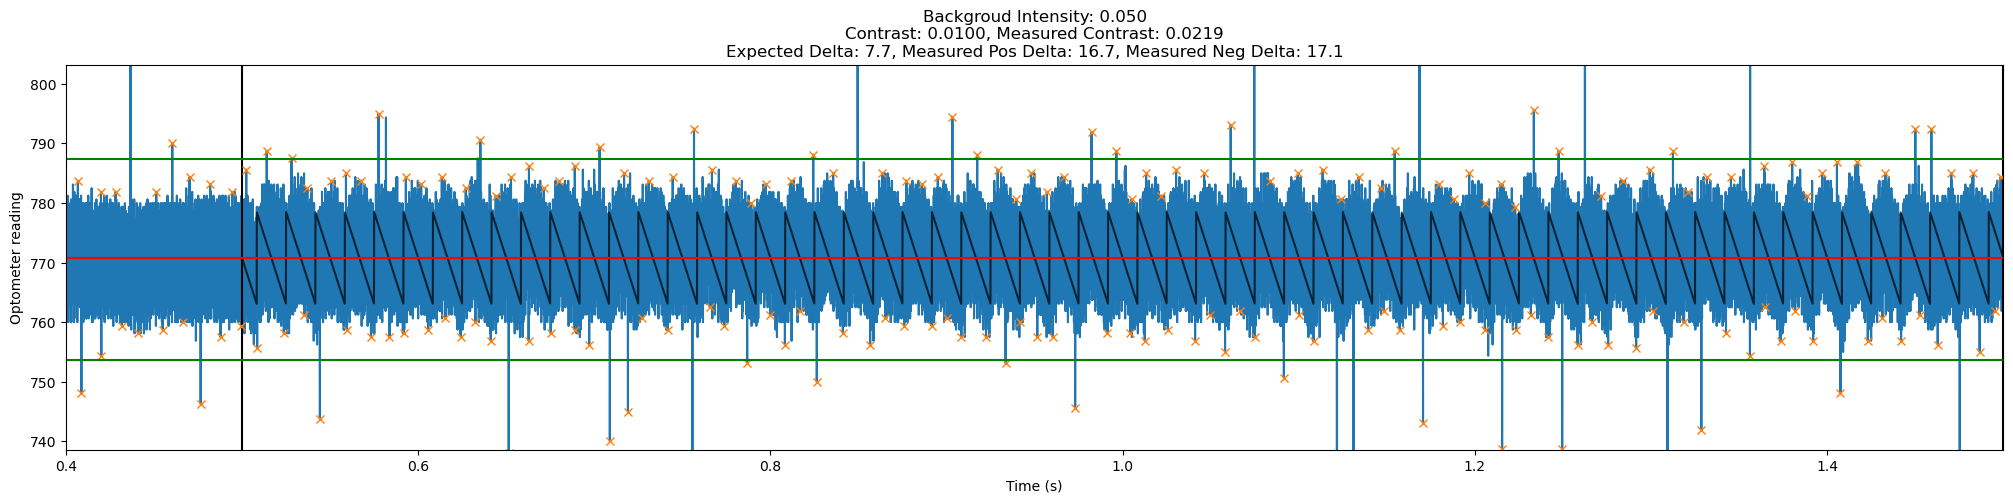

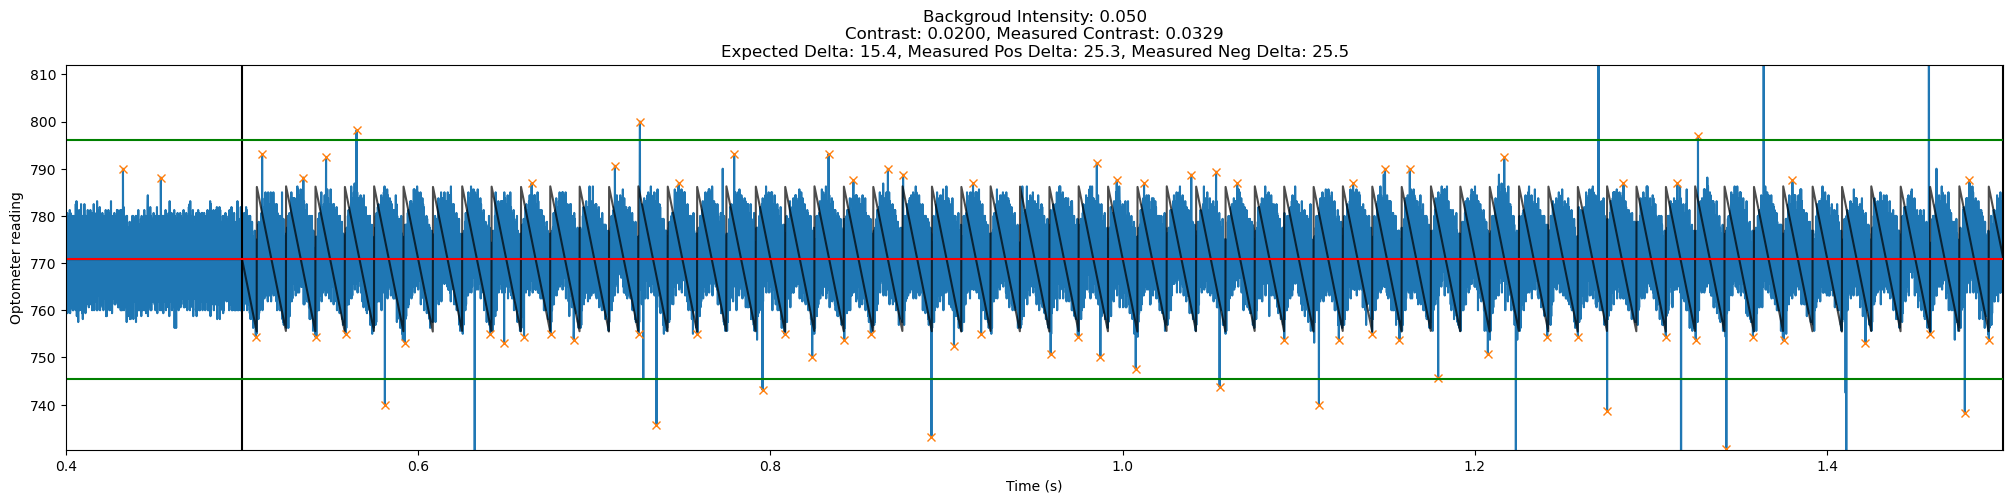

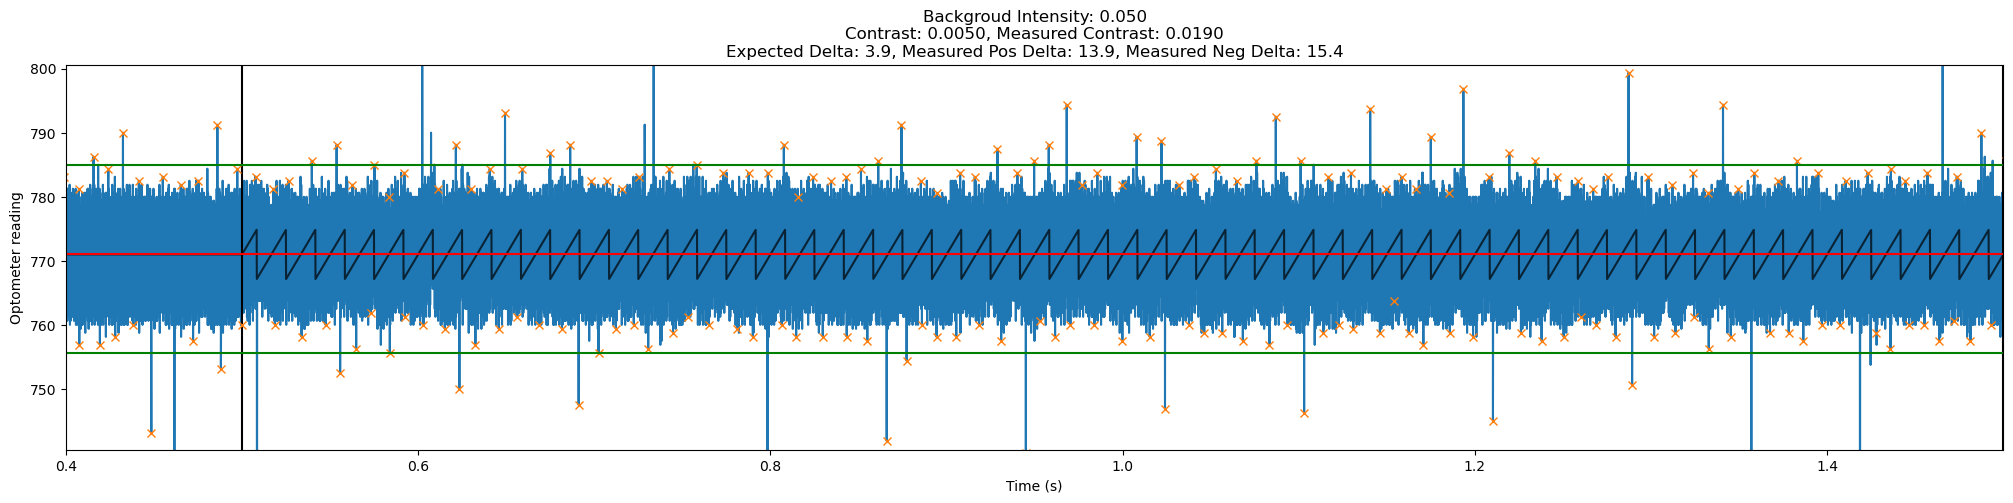

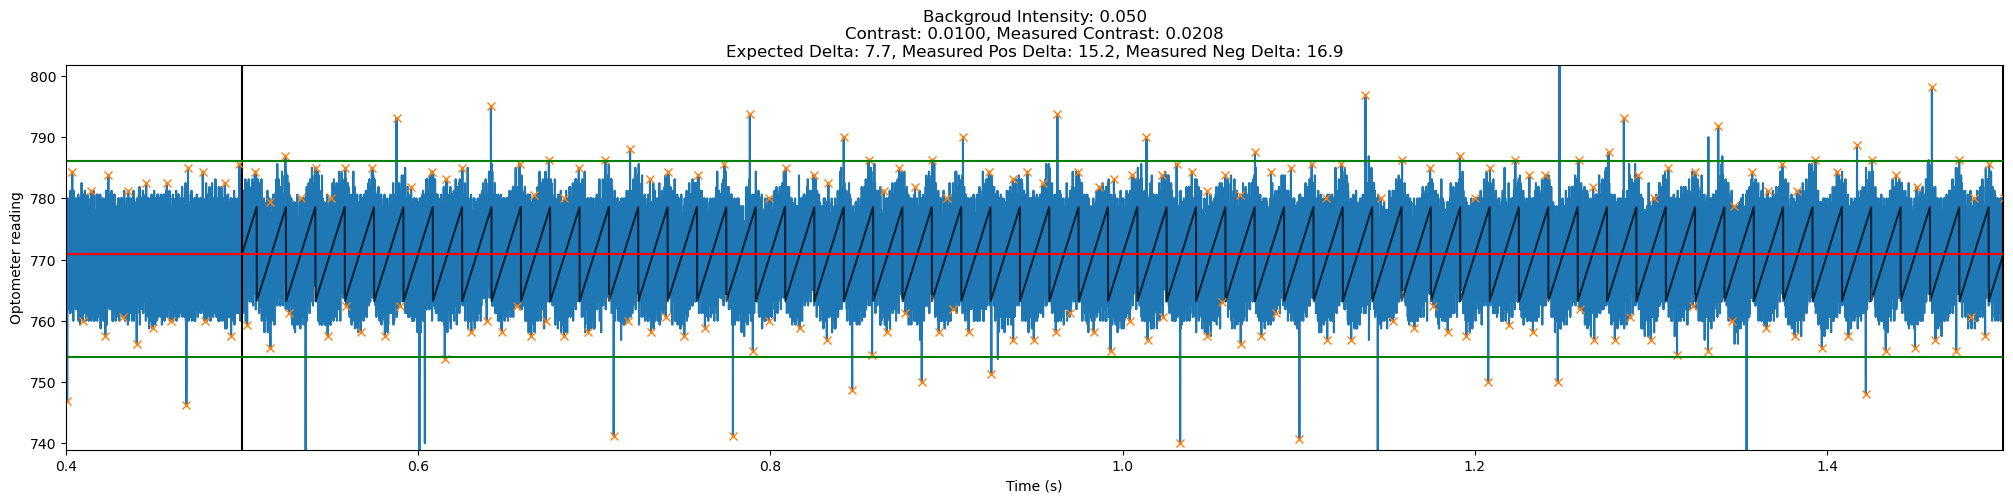

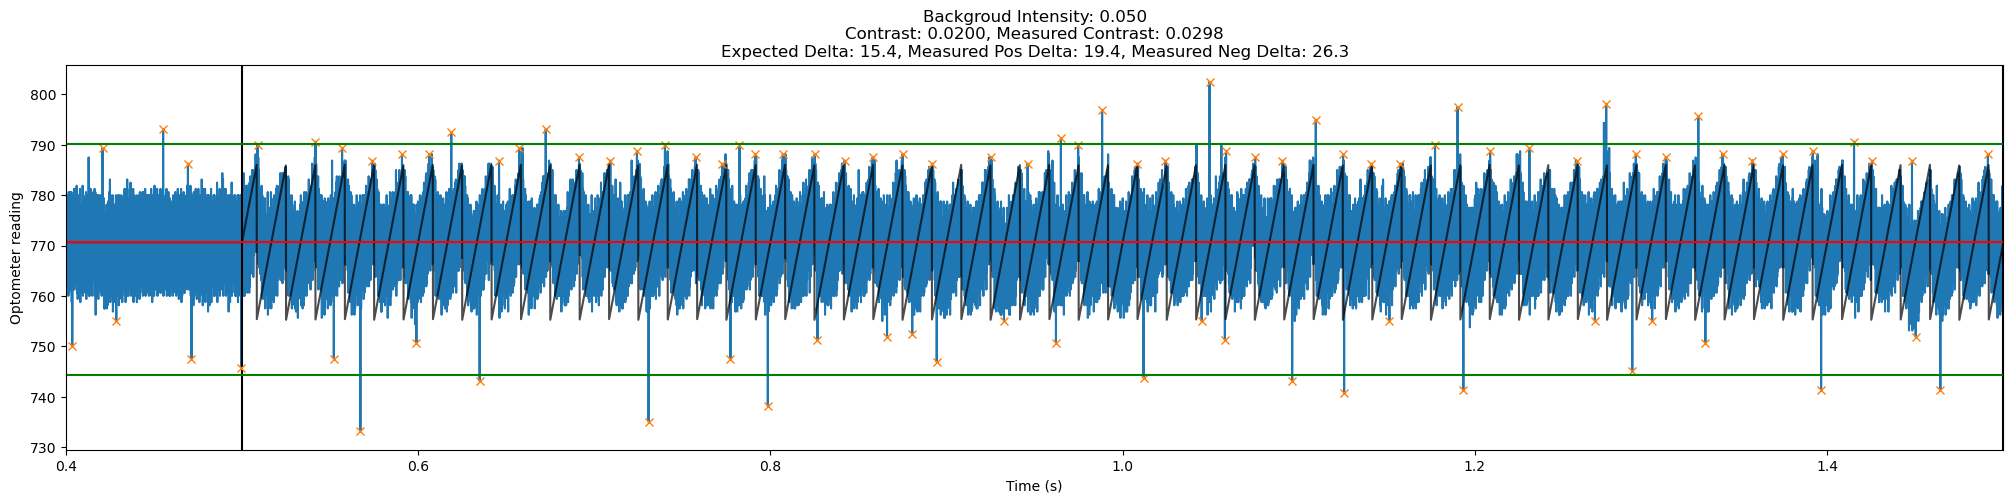

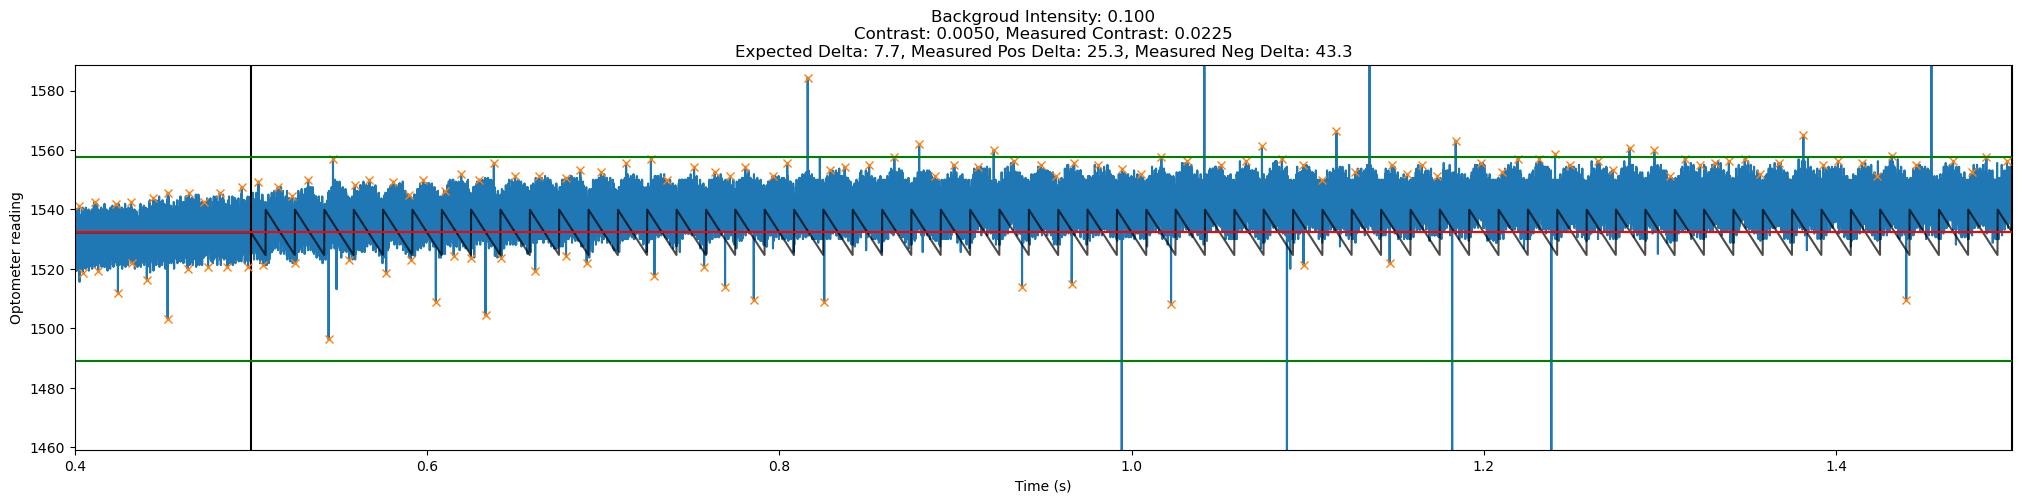

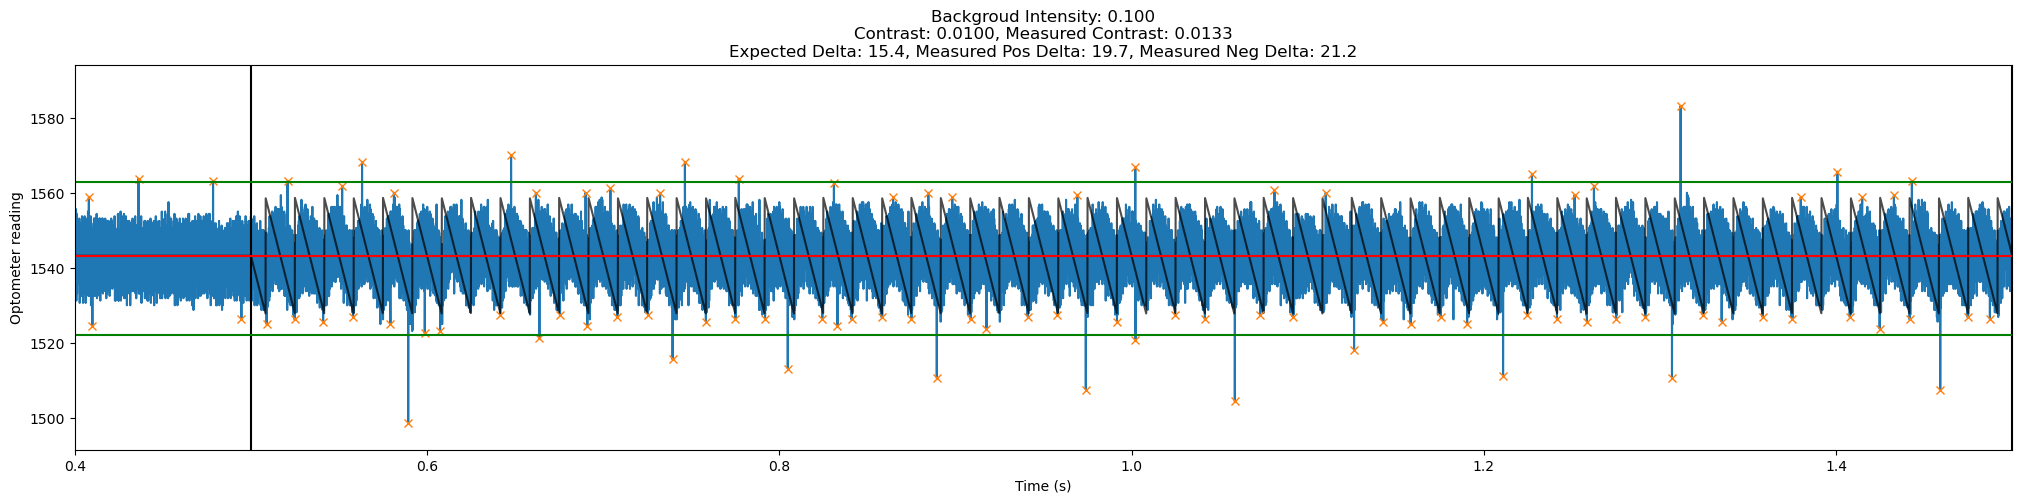

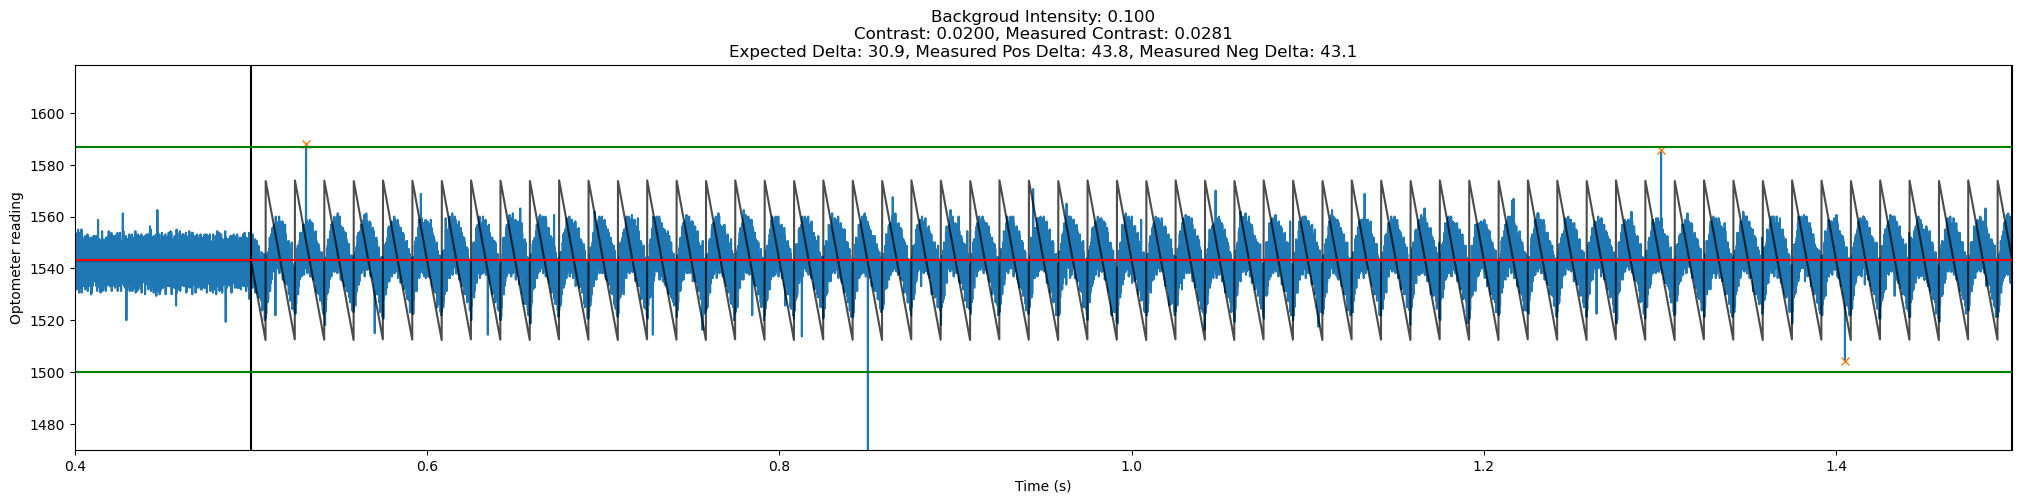

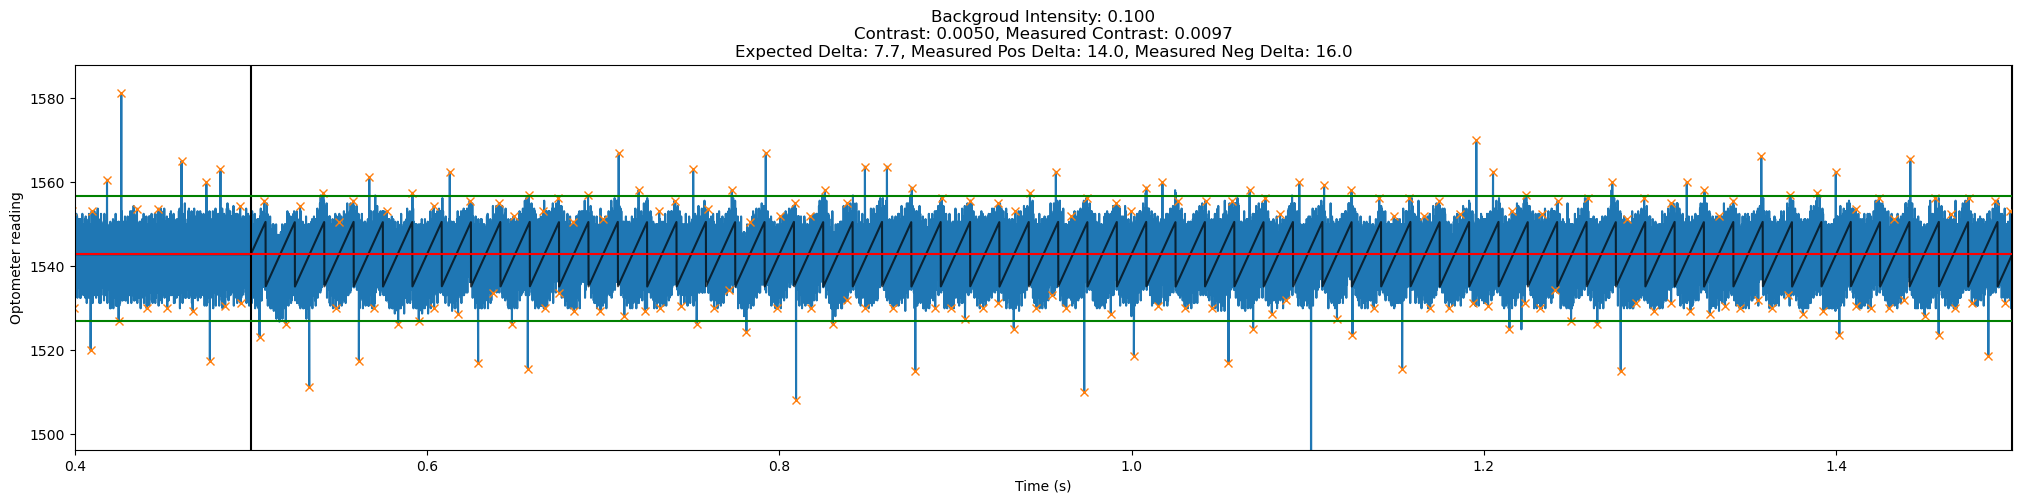

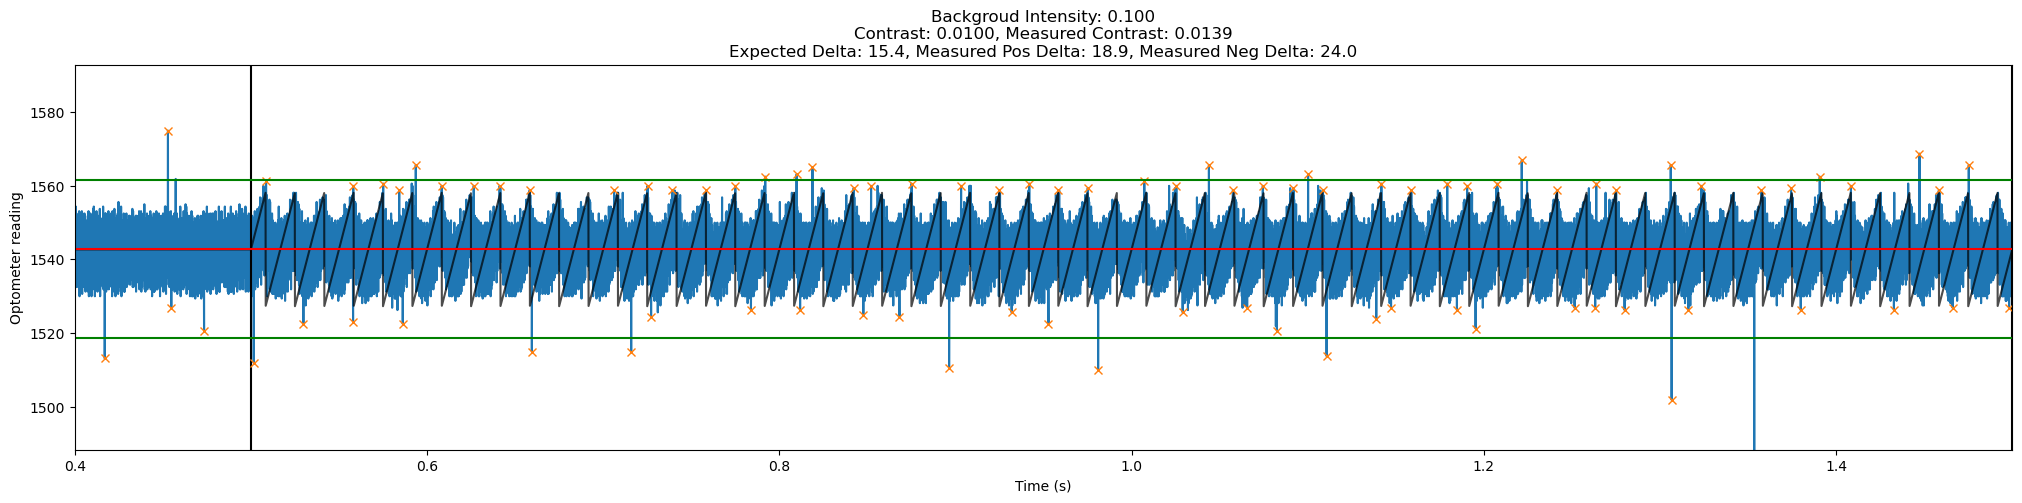

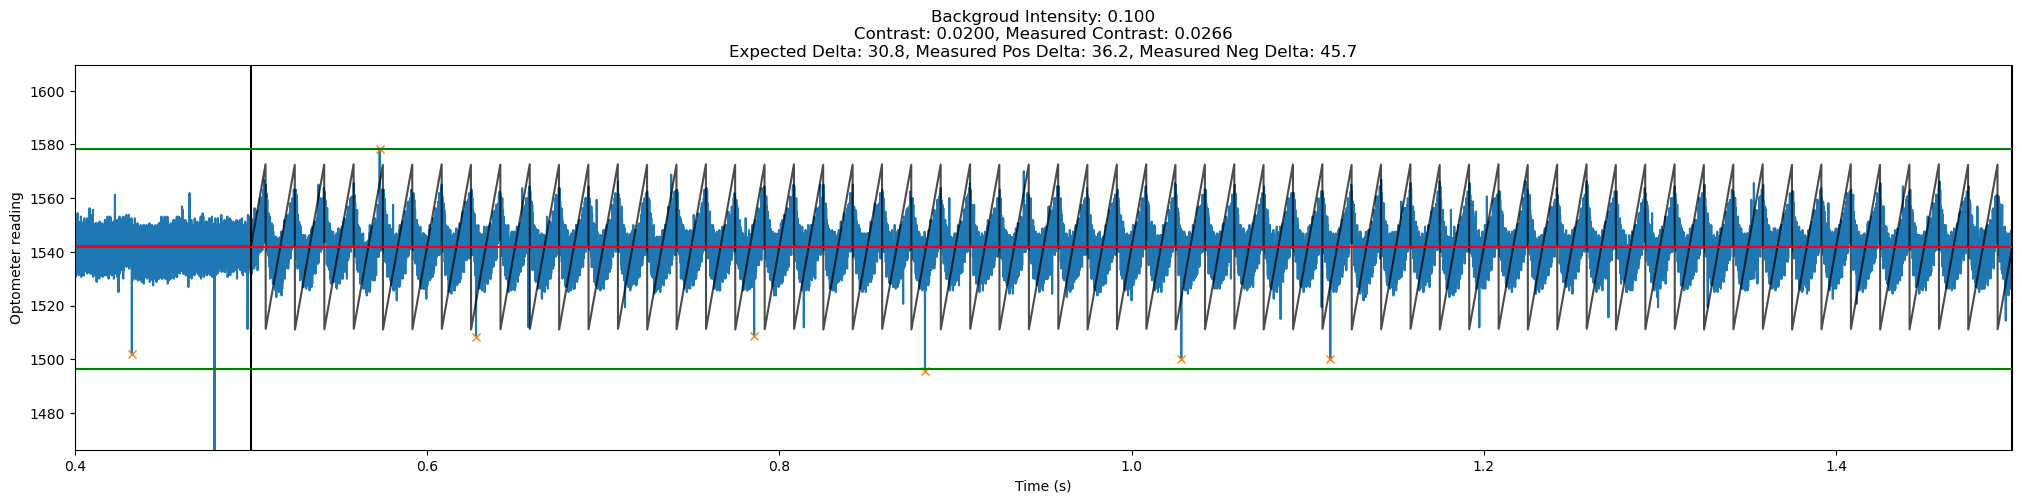

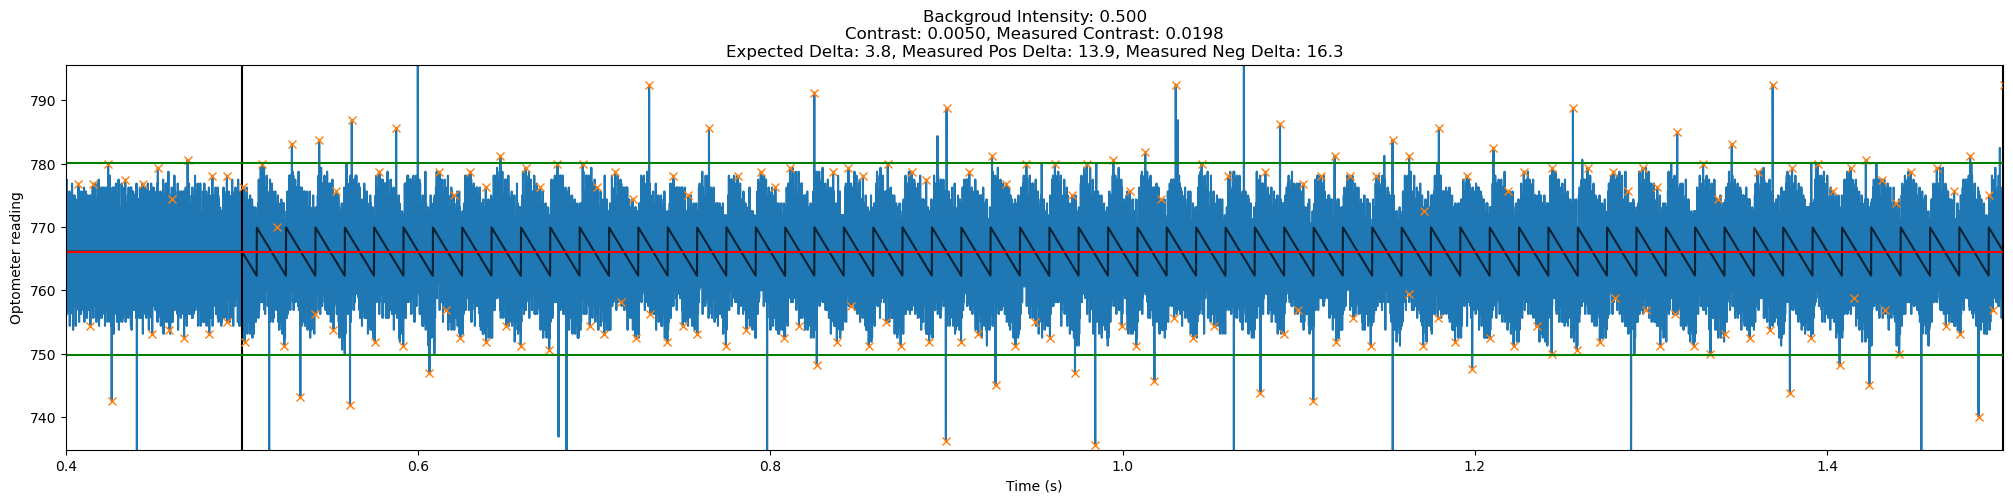

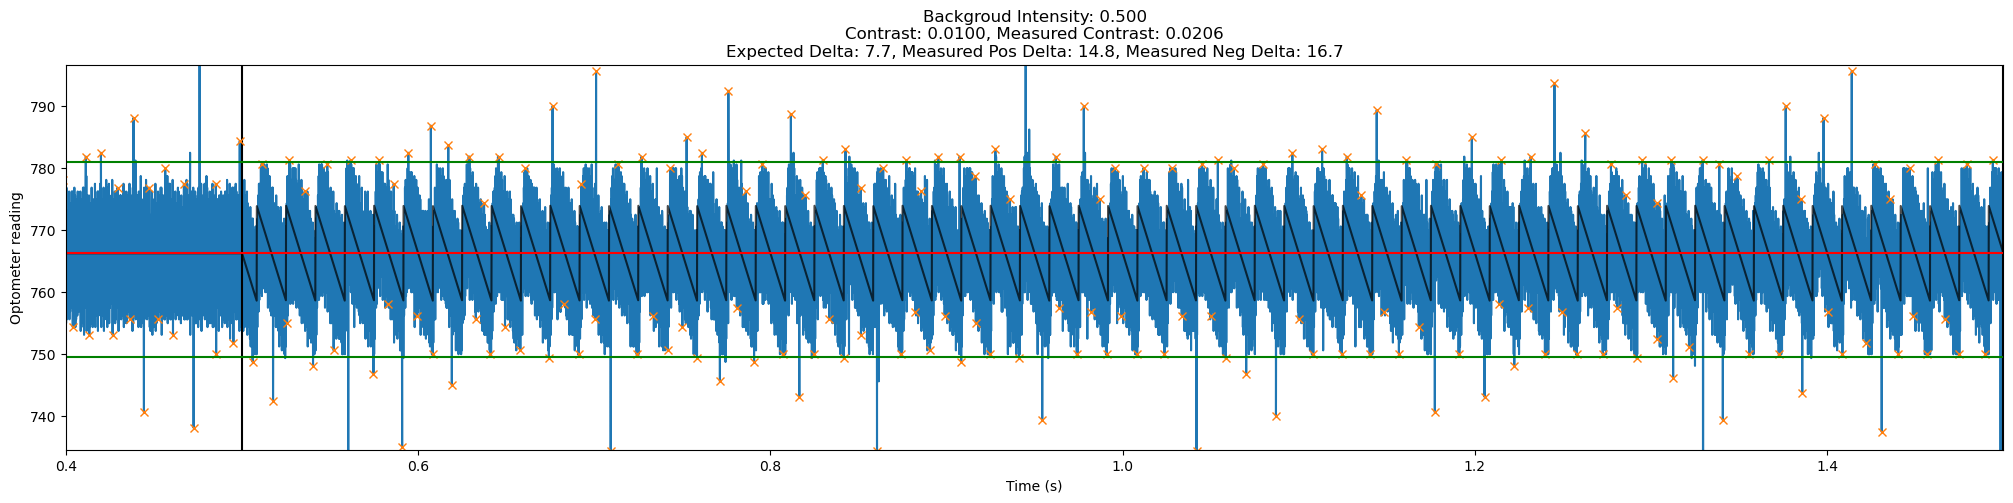

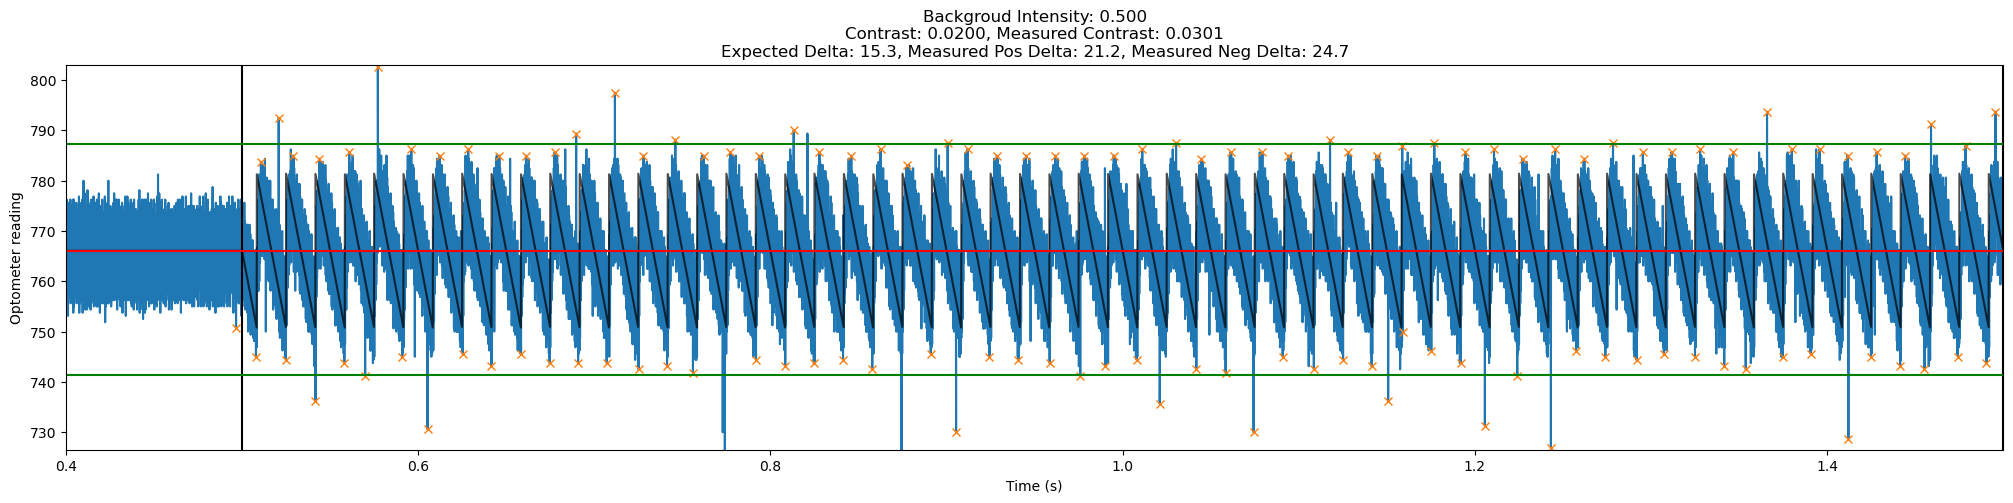

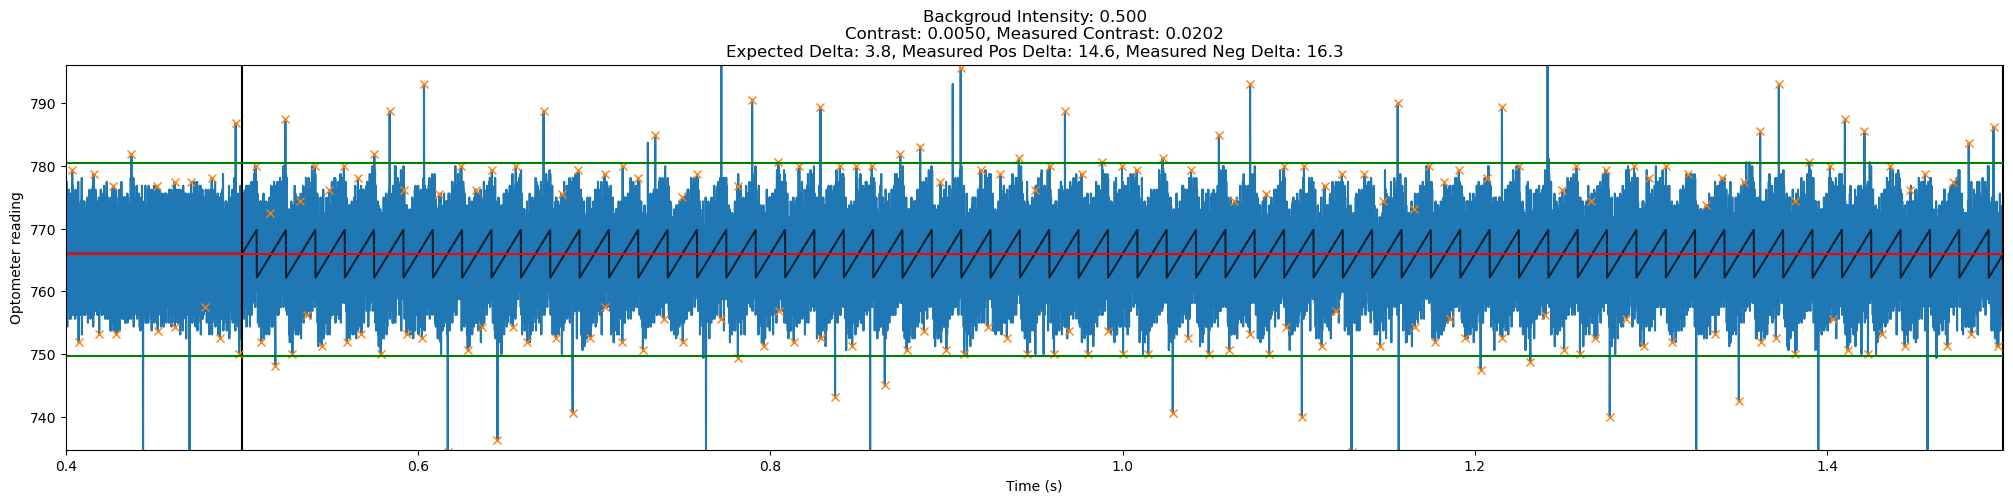

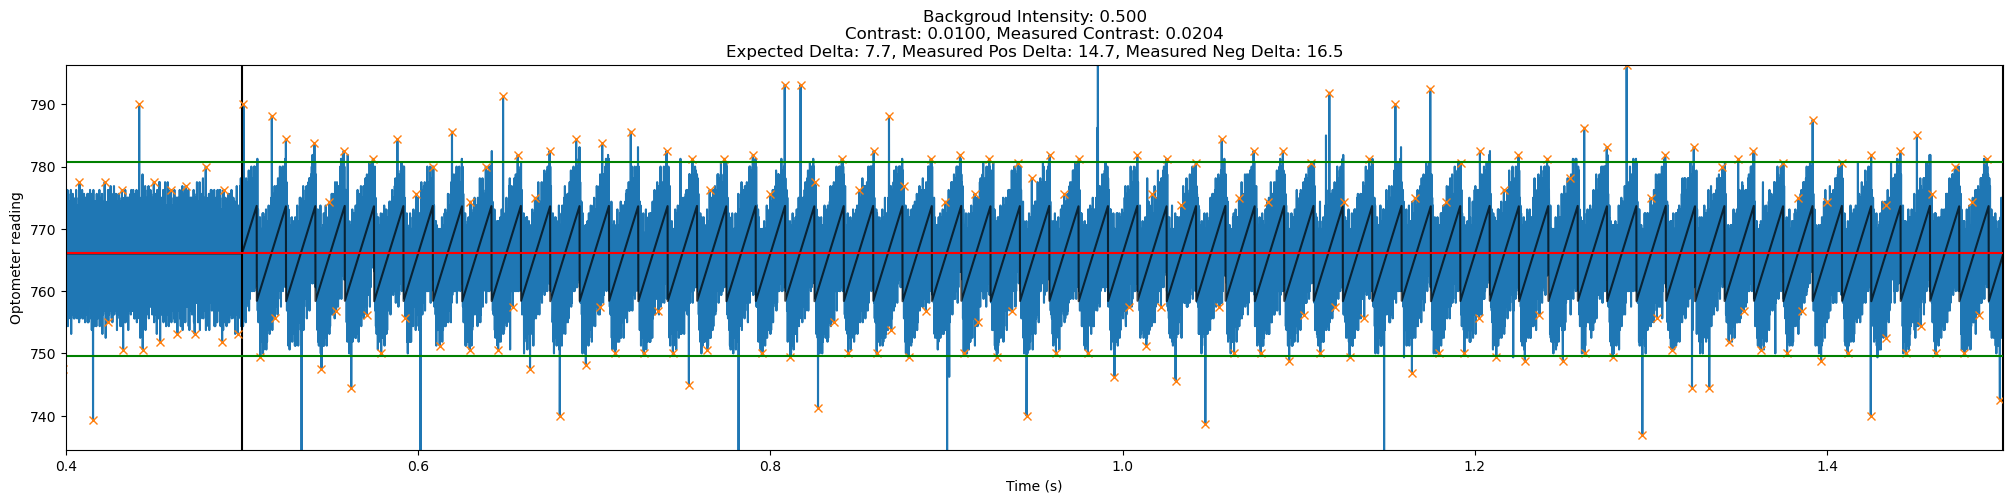

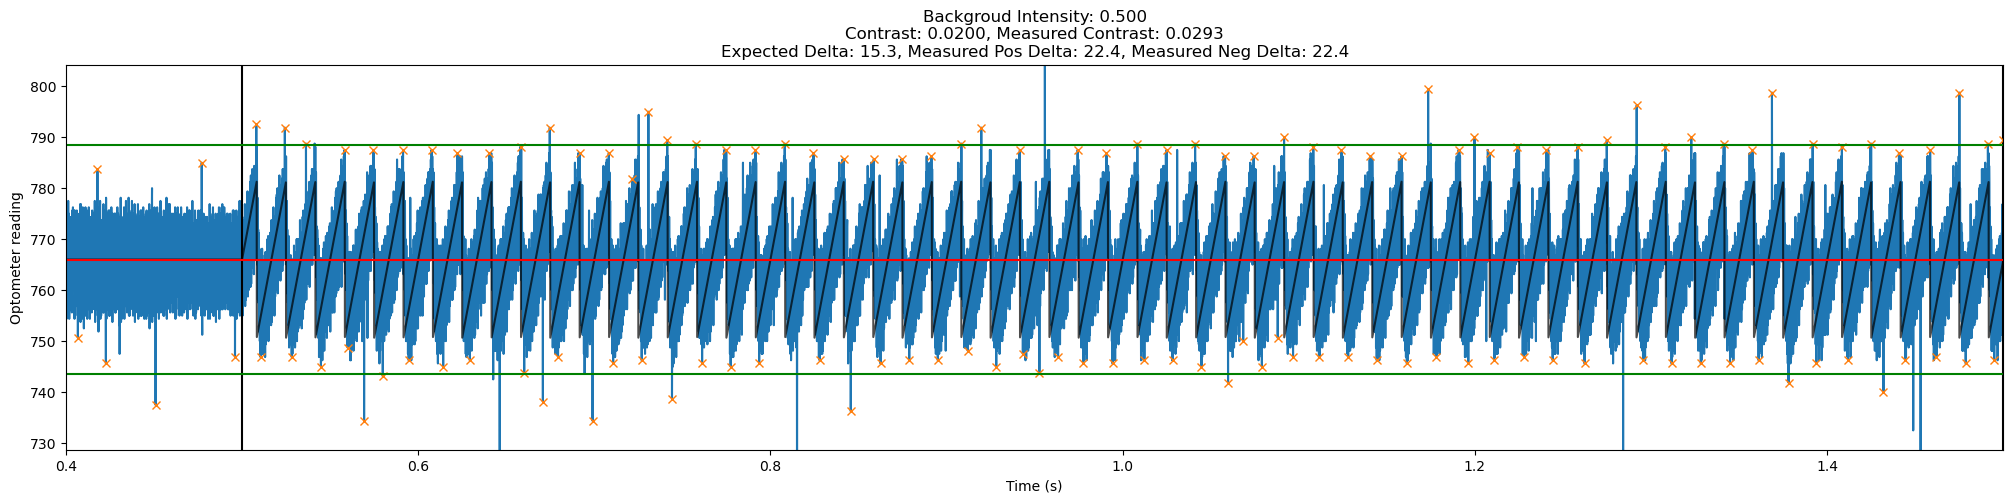

In [207]:
def plot_epoch_data(i_e, df_e, ax=None):
    h5path = df_e['h5path'].iloc[i_e]
    sample_rate = int(df_e['sample_rate'].iloc[i_e])
    epoch_mean = df_e['backgroundIntensity'].iloc[i_e]
    rapidOnOff = df_e['epoch_parameters'].iloc[i_e]['currentRapidOnOff']
    if rapidOnOff:
        polarity = -1
    else:
        polarity = 1
    contrast = df_e['currentContrast'].iloc[i_e]
    temporalFrequency = df_e['epoch_parameters'].iloc[i_e]['currentFrequency']
    preTime = df_e['epoch_parameters'].iloc[i_e]['preTime']
    stimTime = df_e['epoch_parameters'].iloc[i_e]['stimTime']
    tailTime = df_e['epoch_parameters'].iloc[i_e]['tailTime']


    epoch_id = df_e['epoch_id'].iloc[i_e]
    stim_h5path = (schema.Stimulus() & 'parent_id=1' & 'device_name="Green LED"').fetch1('h5path')
    
    with h5py.File(str_h5, 'r') as f:
        data = f[h5path]['data']['quantity']
        # sawtooth = f[stim_h5path]#['data']['quantity']
        # print(sawtooth.keys())


    time = np.arange(0, len(data)/sample_rate, 1/sample_rate)

    pre_mean = np.mean(data[(time>=(preTime-100)/1e3) & (time<=preTime/1e3)])

    sawtooth = sawtooth_generator(preTime, stimTime, tailTime, contrast, pre_mean,#epoch_mean,
                            temporalFrequency, polarity, sample_rate)
    

    
    # This is michelson contrast. Compute expected delta from pre_mean
    ex_delta = pre_mean*contrast
    ph_distance = 80
    peaks, _ = signal.find_peaks(data, height=pre_mean+ex_delta, 
                                distance=ph_distance)
    troughs, _ = signal.find_peaks(-data, height=-(pre_mean-ex_delta),
                                distance=ph_distance)
    if ax is None:
        f, ax = plt.subplots(figsize=(25,5))
    ax.plot(time, data, zorder=0)
    ax.plot(time, sawtooth, c='k', alpha=0.7, zorder=1)
    ax.axvline(0.5, c='k')
    ax.axvline(1.5, c='k')
    ax.set_xlim(0.4,1.5)
    ax.plot(time[peaks], data[peaks], 'x', c='C1')
    ax.plot(time[troughs], data[troughs], 'x', c='C1')

    # Show pre_mean on y-axis
    ax.axhline(pre_mean, c='r')
    avg_peak = np.mean(data[peaks])
    avg_trough = np.mean(data[troughs])
    ax.axhline(avg_peak, c='g')
    ax.axhline(avg_trough, c='g')
    measured_pos_delta = avg_peak - pre_mean
    measured_neg_delta = pre_mean - avg_trough
    measured_contrast = (avg_peak - avg_trough)/(avg_peak + avg_trough)
    
    ylim_scale = 0.02
    ax.set_ylim(avg_trough - avg_trough*ylim_scale, avg_peak + avg_peak*ylim_scale)
    str_title = f'Backgroud Intensity: {epoch_mean:.3f}\n' + \
                f'Contrast: {contrast:.4f}, Measured Contrast: {measured_contrast:.4f}\n' + \
                f'Expected Delta: {ex_delta:.1f}, Measured Pos Delta: {measured_pos_delta:.1f}, Measured Neg Delta: {measured_neg_delta:.1f}'
    ax.set_title(str_title)
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Optometer reading')
    return sawtooth

for i_e in range(len(df_e)):
    _ = plot_epoch_data(i_e, df_e)